Historical match betting odds data on football has been selected for this project. We aim to predict football match outcomes based on one of the main league systems in the country — England.


**Datasets**
The datasets is extracted from 
- *Match Outcomes* (....E0.CSV)
    - Source:https://www.football-data.co.uk/englandm.php
    - Preference:
      - Country: England
      - Season: 2020/21 to Season 2024/25
      - Competition:Premier League
        
- *Club Statics* (club_stats.csv)
    - Source:https://www.premierleague.com/tables?co=1&se=-1&ha=-1
    - Preference:
      - Season: 2020/21 to Season 2024/25
      - Competition:Premier League

- *Team Statics*
    - Source:https://sofifa.com/teams
    - Preference:
      - Season: 2007 to Season 2025

- *Player Statics*
    - Source:https://sofifa.com/players
    - Preference:
      - Season: 2007 to Season 2025

**Our App Goal & Features:**
- Match Results Overview (wins, draws, losses)
- Player Value Prediction (Based on the player's data)
- Team Performance Analysis (goals scored/conceded, home vs away stats)
- Visualizations (time series of goals, heatmaps of fouls/cards, shots on target)
- Filters & Search (by date, teams)
- Prediction Module (basic prediction based on stats or odds)

# Data Extraction and Preprocess

In [136]:
import os
import sqlite3
import glob
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

In [74]:
# Load Datasets
folder_path = 'data/in_match_predict'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('E0.csv')]

dataframes = []
column_sets = []
all_cols = set()

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        # Extract and format season
        raw_season = file.split(' ')[1]  # e.g. '2020-2021'
        start_year, end_year = raw_season.split('-')
        season = f"{start_year}/{end_year[2:]}"  # e.g. '2020/21'
        
        df = pd.read_csv(file_path)
        df['Season'] = season
        dataframes.append(df)

        header_df = pd.read_csv(file_path, nrows=0)
        cols = set(header_df.columns)
        column_sets.append(cols)
        all_cols.update(cols)
    except Exception as e:
        print(f"Error reading {file}: {e}")

merged_df = pd.concat(dataframes, ignore_index=True)

common_cols = set.intersection(*column_sets)
non_shared_cols = all_cols - common_cols

#Save the csv file to dataset folder
#merged_df.to_csv(os.path.join(folder_path, 'E0_merged.csv'), index=False)
#print(f"\n Merged dataset saved to: {os.path.join(folder_path, 'E0_merged.csv')}")

#merged_df.to_csv("E0_merged.csv", index=False)
print(f"The size of merged dataset is : {merged_df.shape}")

The size of merged dataset is : (1880, 133)


In [3]:
#Sort the dataset based on Division and Year

merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)
merged_df['Year'] = merged_df['Date'].dt.year

merged_df['Div_num'] = merged_df['Div'].str.extract(r'E(\d)').astype(int)

merged_df = merged_df.sort_values(by=['Year', 'Div_num'], ascending=[True, False])

merged_df.drop(columns='Div_num' , inplace=True)

In [4]:
merged_df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Year
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,E0,2020-09-12,17:30,Liverpool,Leeds,4,3,H,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
3,E0,2020-09-12,20:00,West Ham,Newcastle,0,2,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
4,E0,2020-09-13,14:00,West Brom,Leicester,0,3,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


After sorting merged_df , we can see there are a lot of missing values appears ; This is because some files may have extra or missing columns (e.g., new betting markets added in later seasons), or columns that exist only in certain files.

By looking at the merged dataset , here are some information for user to know before further cleaning the dataset: 

Some Header Information are as below:

| Column Header  | Meanings | Details |
| -------------- | -------- | ------- |
| `Div` | Division of the match | `E0`: Premier Leagu |
| `Date` | The Match date |  |
| `Time` | Kick-off time |  |
| `HomeTeam` , `AwayTeam` | Names of home and away teams |  |
| `FTHG` , `FTAG` | Full Time Home Goals, Away Goals |  |
| `FTR` | Full-Time Result (H, D, A) |  |
| `HTHG`, `HTAG`, `HTR` | Half-Time Stas (Home Goals, Away Goals, Result) |  |
| `HS`, `AS`, `HST`, `AST` | Home team / Away Team (Shots, Shots on Target)  |  |
| `HF`, `AF`, `HC`, `AC`, `HY`, `AY`, `HR`, `AR` | Home team / Away Team (Fouls, Corners, Cards(Yellow/Read)) |  |
| `B365H`, `B365D`, `B365A`...`WHH`,`WHD`,`WHA`| betting houses odds (Home, Draw, Away) | The betting houses are: Bet365, Pinnacle, Bet&Win, William Hill |
| `MaxH`,`MaxD`,`MaxA` | maximum betting odds offered| |
| `AvgH`, `AvgD`, `AvgA` | Average odds across bookies|  |

There are other columns like `B365>2.5`, `B365<2.5`, `P>2.5`, these indicates probabilities for the total number of goals scored in a match. 

In [11]:
# Load club stats
club_df = pd.read_csv(os.path.join(folder_path, 'club_stats.csv'))

club_df.head()

,Season,Position,Club,Played,Won,Drawn,Lost
0,2024/25,1,Liverpool,37,25,8,4
1,2024/25,2,Arsenal,37,19,14,4
2,2024/25,3,Manchester City,37,20,8,9
3,2024/25,4,Newcastle United,37,20,6,11
4,2024/25,5,Chelsea,37,19,9,9


In [13]:
# Check Unquie Team Name
print("\n------Unique HomeTeams in merged_df------\n")
print(merged_df['HomeTeam'].unique())

print("\n------ Unique AwayTeams in merged_df-------\n")
print(merged_df['AwayTeam'].unique())

print("\n------Unique Clubs in club_df------\n")
print(club_df['Club'].unique())


------Unique HomeTeams in merged_df------

['Fulham' 'Crystal Palace' 'Liverpool' 'West Ham' 'West Brom' 'Tottenham'
 'Brighton' 'Sheffield United' 'Everton' 'Leeds' 'Man United' 'Arsenal'
 'Southampton' 'Newcastle' 'Chelsea' 'Leicester' 'Aston Villa' 'Wolves'
 'Burnley' 'Man City' 'Brentford' 'Watford' 'Norwich' 'Bournemouth'
 "Nott'm Forest" 'Luton' 'Ipswich']

------ Unique AwayTeams in merged_df-------

['Arsenal' 'Southampton' 'Leeds' 'Newcastle' 'Leicester' 'Everton'
 'Chelsea' 'Wolves' 'West Brom' 'Fulham' 'Crystal Palace' 'West Ham'
 'Tottenham' 'Brighton' 'Liverpool' 'Burnley' 'Sheffield United'
 'Man City' 'Man United' 'Aston Villa' 'Brentford' 'Norwich' 'Watford'
 "Nott'm Forest" 'Bournemouth' 'Luton' 'Ipswich']

------Unique Clubs in club_df------

['Liverpool' 'Arsenal' 'Manchester City' 'Newcastle United' 'Chelsea'
 'Aston Villa' 'Nottingham Forest' 'Brighton & Hove Albion' 'Brentford'
 'Fulham' 'Bournemouth' 'Crystal Palace' 'Everton'
 'Wolverhampton Wanderers' 'West Ha

We can see some of the name in HomeTeam and AwayTeam does not match the name in Club. So we need to change it for consistency.

In [16]:
# Mapping dictionary from short names to full club names
team_name = {
    'Man City': 'Manchester City',
    'Man United': 'Manchester United',
    'Sheffield United': 'Sheffield United',
    'West Ham': 'West Ham United',
    'West Brom': 'West Bromwich Albion',
    'Brighton': 'Brighton & Hove Albion',
    'Wolves': 'Wolverhampton Wanderers',
    'Spurs': 'Tottenham Hotspur',
    'Tottenham': 'Tottenham Hotspur',
    'Newcastle': 'Newcastle United',
    "Nott'm Forest": 'Nottingham Forest',
    'Leeds': 'Leeds United',
    'Norwich': 'Norwich City',
    'Luton': 'Luton Town',
    'Ipswich': 'Ipswich Town',
    'Leicester': 'Leicester City',
}

def map_team_name(name):
    return team_name.get(name, name)

# Map to full club names for HomeTeam and AwayTeam
merged_df['HomeTeam'] = merged_df['HomeTeam'].apply(map_team_name)
merged_df['AwayTeam'] = merged_df['AwayTeam'].apply(map_team_name)

# Strip any leading/trailing spaces from column names
club_df.columns = club_df.columns.str.strip()

# Prepare home stats with renamed columns
home_stats = club_df.rename(columns={
    'Club': 'HomeTeam',
    'Position': 'HPos',
    'Played': 'HPlayed',
    'Won': 'HWon',
    'Drawn': 'HDrawn',
    'Lost': 'HLost'
})

# Prepare away stats with renamed columns
away_stats = club_df.rename(columns={
    'Club': 'AwayTeam',
    'Position': 'APos',
    'Played': 'APlayed',
    'Won': 'AWon',
    'Drawn': 'ADrawn',
    'Lost': 'ALost'
})

# Merge df with the home_stats and away_stats
merged_df = merged_df.merge(home_stats, how='left', on=['Season', 'HomeTeam'])
merged_df = merged_df.merge(away_stats, how='left', on=['Season', 'AwayTeam'])


In [18]:
# NaN Summary 
na_count = merged_df.isna().sum()
na_percentage = (na_count / len(merged_df)) * 100

na_summary = pd.DataFrame({
    'NaN Count': na_count,
    'NaN Percentage (%)': na_percentage.round(2)
})

na_summary = na_summary.sort_values(by='NaN Percentage (%)', ascending=False)

na_summary

,NaN Count,NaN Percentage (%)
1XBD,1529,81.33
1XBH,1529,81.33
1XBA,1529,81.33
BFE<2.5,1523,81.01
BFE>2.5,1523,81.01
...,...,...
AvgA,0,0.00
AvgD,0,0.00
AvgH,0,0.00
MaxA,0,0.00


By looking at the Nan Summary , we can tell most of the column which has large percentages are those odds provided by different bookmakers ; This might be because those bookmakers will only be opend in some specific matches.

In [21]:
# Defines the columns

cols_to_keep = [
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    'HS', 'AS', 'HST', 'AST',
    'HF', 'AF', 'HC', 'AC', # Fouls / Corners
    'HY', 'AY', 'HR', 'AR', # Yellow/Red Cards
    'B365H', 'B365D', 'B365A', # B356
    'BWH', 'BWD', 'BWA', # Pinnacle
    'PSH', 'PSD', 'PSA', # Bet&Win
    'WHH', 'WHD', 'WHA', # William Hill
    'Season',
    'HPos','HPlayed','HWon','HDrawn','HLost',
    'APos','APlayed','AWon','ADrawn','ALost'
]

# List of columns to convert
numeric_cols = [
    'FTHG', 'FTAG', 'HTHG', 'HTAG',
    'HS', 'AS', 'HST', 'AST',
    'HF', 'AF', 'HC', 'AC',  # Fouls / Corners
    'HY', 'AY', 'HR', 'AR',  # Yellow/Red Cards
    'B365H', 'B365D', 'B365A',  # B365
    'BWH', 'BWD', 'BWA',        # Pinnacle
    'PSH', 'PSD', 'PSA',        # Bet&Win
    'WHH', 'WHD', 'WHA',       # William Hill
    'HPos','HPlayed','HWon','HDrawn','HLost',
    'APos','APlayed','AWon','ADrawn','ALost'
]

betting_cols = [
    'B365H', 'B365D', 'B365A',
    'BWH', 'BWD', 'BWA',
    'PSH', 'PSD', 'PSA',
    'WHH', 'WHD', 'WHA'
]

In [23]:
# Filter the DataFrame
merged_df = merged_df[cols_to_keep]

In [25]:
# Compute NaN Summary after filerting 
na_count = merged_df.isna().sum()
na_percentage = (na_count / len(merged_df)) * 100

na_summary = pd.DataFrame({
    'NaN Count': na_count,
    'NaN Percentage (%)': na_percentage.round(2)
}).sort_values(by='NaN Percentage (%)', ascending=False)

# Display the result
na_summary

,NaN Count,NaN Percentage (%)
BWH,123,6.54
BWD,123,6.54
BWA,123,6.54
WHA,71,3.78
WHH,71,3.78
WHD,71,3.78
Div,0,0.00
B365A,0,0.00
PSH,0,0.00
PSD,0,0.00


After extrating the useful columns , we can still see the NANs exist in some of the columns with small percentage ; Like we have mentioned earlier, these might be because 
those bookmakers will only be opend in specific matches;
Consider the following reasons :
- Those are leftovers bookmarkers in all files which is helpful in prediction
- There are only small percentage of NANs in each columns

We will impute the odds with 0 to those bookmakers

In [28]:
# Impute betting columns
merged_df[betting_cols] = merged_df[betting_cols].fillna(0)

In [30]:
# NAN Count
merged_df.isna().sum()

Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
B365H       0
B365D       0
B365A       0
BWH         0
BWD         0
BWA         0
PSH         0
PSD         0
PSA         0
WHH         0
WHD         0
WHA         0
Season      0
HPos        0
HPlayed     0
HWon        0
HDrawn      0
HLost       0
APos        0
APlayed     0
AWon        0
ADrawn      0
ALost       0
dtype: int64

**The module below is used for saving all the data which is needed for building the pre match predict model**

The used data was fetched by the python file:
- download_match_data.py
- get_player_data.py
- get_team_data.py

In [125]:
# This function is used for saving match data
def save_match_data(connection, cursor):
    create_match_stats = """CREATE TABLE match_stats (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        home_team TEXT NOT NULL,
        away_team TEXT NOT NULL,
        season TEXT NOT NULL,
        ftr TEXT,
        b365h REAL,
        b365d REAL,
        b365a REAL,
        b365_prob_h REAL,
        b365_prob_d REAL,
        b365_prob_a REAL
    );"""
    cursor.execute("DROP TABLE IF EXISTS match_stats")
    cursor.execute(create_match_stats)

    team_name = {
        # England
        "Man City": "Manchester City",
        "Man United": "Manchester United",
        "Spurs": "Tottenham Hotspur",
        "Wolves": "Wolverhampton Wanderers",
        "Newcastle": "Newcastle United",
        "West Brom": "West Bromwich Albion",
        "Sheff Utd": "Sheffield United",
        "Nott'm Forest": "Nottingham Forest",
        "Leeds": "Leeds United",
        "Brighton": "Brighton & Hove Albion",
        "Birmingham": "Birmingham City",
        "Blackburn": "Blackburn Rovers",
        "Bolton": "Bolton Wanderers",
        "Stoke": "Stoke City",
        "Wigan": "Wigan Athletic",
        "West Ham": "West Ham United",

        # France
        "PSG": "Paris Saint-Germain",
        "AS Nancy": "AS Nancy-Lorraine",
        "Arles": "AC Arles-Avignon",
        "Auxerre": "AJ Auxerre",
        "Brest": "Stade Brestois 29",
        "Caen": "Stade Malherbe Caen",
        "Lorient": "FC Lorient",
        "Nice": "OGC Nice",
        "Saint Etienne": "AS Saint-Étienne",
        "Sochaux": "FC Sochaux-Montbéliard",

        # Germany
        "Bayern Munich": "FC Bayern München",
        "Wolfsburg": "VfL Wolfsburg",
        "Monchengladbach": "Borussia Mönchengladbach",
        "Nurnberg": "1. FC Nürnberg",
        "St Pauli": "FC St. Pauli",
        "Hoffenheim": "TSG 1899 Hoffenheim",

        # Italy
        "AC Milan": "Milan",
        "Inter": "Internazionale",
        "Lazio": "SS Lazio",
        "Cagliari": "Cagliari Calcio",
        "Cesena": "AC Cesena",
        "Lecce": "US Lecce",

        # Spain
        "Atletico": "Atlético Madrid",
        "Mallorca": "RCD Mallorca",
        "Hercules": "Hércules CF",
        "Racing": "Racing Santander",
        "Sporting": "Sporting Gijón",
        "Zaragoza": "Real Zaragoza",
        "Real Madrid": "Real Madrid CF",
        "Barcelona": "FC Barcelona",
    }

    def map_team_name(name):
        return team_name.get(name, name)

    folder_path = 'data/match_data'
    files = glob.glob(f'{folder_path}/**/*.csv', recursive=True)
    dataframes = []

    for file in files:
        try:
            # Extract and format season
            raw_season = os.path.splitext(os.path.basename(file))[0].split('_')[1]  # e.g. '2020-2021'
            start_year, end_year = raw_season.split('-')
            season = f"{start_year}/{end_year[2:]}"  # e.g. '2020/21'
            df_match = pd.read_csv(file)
            df_match['Season'] = season
            df_match = df_match[['HomeTeam', 'AwayTeam', 'Season', 'FTR', 'B365H', 'B365D', 'B365A']]
            inverse = 1 / df_match[['B365H', 'B365D', 'B365A']]
            total = inverse.sum(axis=1)
            df_match['b365_prob_H'] = inverse['B365H'] / total
            df_match['b365_prob_D'] = inverse['B365D'] / total
            df_match['b365_prob_A'] = inverse['B365A'] / total
            dataframes.append(df_match)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df['HomeTeam'] = merged_df['HomeTeam'].apply(map_team_name)
    merged_df['AwayTeam'] = merged_df['AwayTeam'].apply(map_team_name)
    merged_df.columns = ['home_team', 'away_team', 'season', 'ftr', 'b365h', 'b365d', 'b365a', 'b365_prob_h',
                         'b365_prob_d', 'b365_prob_a']
    merged_df.dropna(inplace=True)
    merged_df.to_sql('match_stats', connection, if_exists='append', index=False)
    connection.commit()

In [123]:
# This function is used for saving team data
def save_team_data(connection, cursor):
    folder_path = 'data/team_data'
    files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    create_team_stats = """CREATE TABLE team_stats (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        team TEXT NOT NULL,
        league TEXT NOT NULL,
        year TEXT NOT NULL,
        overall INTEGER,
        attack INTEGER,
        midfield INTEGER,
        defence INTEGER,
        players INTEGER,
        starting_xi_avg_age REAL);"""

    cursor.execute("DROP TABLE IF EXISTS team_stats")
    cursor.execute(create_team_stats)

    dataframes = []

    for file in files:
        file_path = os.path.join(folder_path, file)
        df_team = pd.read_csv(file_path)
        df_team[['Team', 'League']] = df_team['Name'].str.split('\n', expand=True)
        df_team['Year'] = os.path.basename(file)[-8:-4]
        df_team.drop(columns=['Name'], inplace=True)
        df_team.rename(columns={'Starting XI average age': 'starting_xi_avg_age'}, inplace=True)
        df_team = df_team[['Team', 'League', 'Year', 'Overall', 'Attack', 'Midfield', 'Defence', 'Players', 'starting_xi_avg_age']]
        dataframes.append(df_team)

    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.to_sql('team_stats', connection, if_exists='append', index=False)
    connection.commit()

In [121]:
# This function is used for saving player data
def save_player_data(connection, cursor):
    folder_path = 'data/player_data'
    files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    print(len(files))
    create_player_stats = """CREATE TABLE player_stats (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        full_name TEXT NOT NULL,
        age INTEGER,
        year TEXT NOT NULL,
        overall_rating INTEGER,
        potential INTEGER,
        best_position TEXT,
        team TEXT,
        height_cm REAL,
        weight_kg REAL,
        value REAL,
        wage REAL,
        short_passing INTEGER,
        dribbling INTEGER,
        stamina INTEGER,
        total_goalkeeping INTEGER
        );"""

    cursor.execute("DROP TABLE IF EXISTS player_stats")
    cursor.execute(create_player_stats)

    dataframes = []

    for file in files:
        file_path = os.path.join(folder_path, file)
        df_player = pd.read_csv(file_path)
        df_player['name'] = df_player['Name'].str.split('\n').str[0]
        df_player['year'] = os.path.basename(file)[-8:-4]

        df_player['team'] = df_player['Team & Contract'].str.split('\n').str[0]
        df_player['contract'] = df_player['Team & Contract'].str.split('\n').str[1]

        df_player['height_cm'] = df_player['Height'].str.extract(r'(\d+)cm').astype(float)

        df_player['weight_kg'] = df_player['Weight'].str.extract(r'(\d+)kg').astype(float)

        for col in ['Stamina', 'Dribbling', 'Short passing']:
            df_player[col] = df_player[col].astype(str).str.extract(r'(\d+)').astype(float)

        df_player.rename(columns={
            'Full Name': 'full_name',
            'Age': 'age',
            'Overall rating': 'overall_rating',
            'Potential': 'potential',
            'Best position': 'best_position',
            'Value': 'value',
            'Wage': 'wage',
            'Short passing': 'short_passing',
            'Dribbling': 'dribbling',
            'Stamina': 'stamina',
            'Total goalkeeping': 'total_goalkeeping'
        }, inplace=True)

        cleaned_df = df_player[[
            'full_name', 'age', 'year', 'overall_rating', 'potential', 'best_position',
            'team', 'height_cm', 'weight_kg',
            'value', 'wage', 'short_passing', 'dribbling', 'stamina', 'total_goalkeeping'
        ]]
        dataframes.append(cleaned_df)

    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.to_sql('player_stats', connection, if_exists='append', index=False)
    connection.commit()

In [116]:
# Save data into allData.sl3
database_path = os.path.join('data/allData.sl3')
connection = sqlite3.connect(database_path)
cursor = connection.cursor()
save_match_data(connection, cursor)
save_team_data(connection, cursor)
save_player_data(connection, cursor)
cursor.close()
connection.close()

# Visualization 

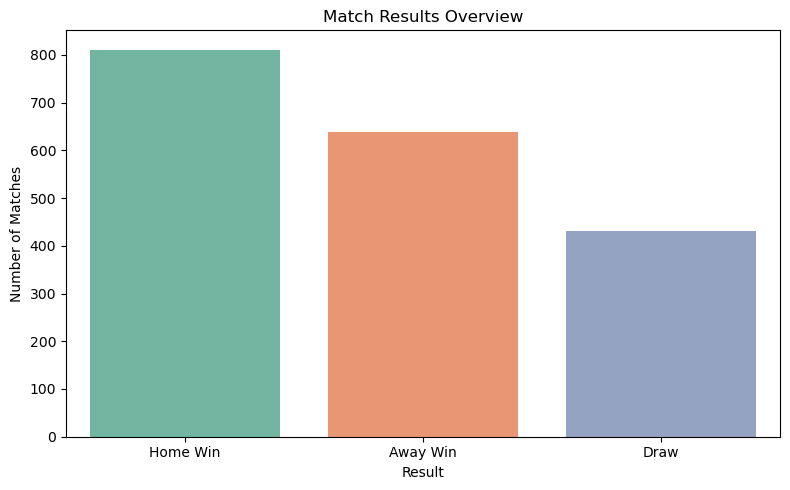

In [33]:
#Match Results Overview
# Match results: H = Home win, A = Away win, D = Draw
result_counts = merged_df['FTR'].value_counts().rename(index={'H': 'Home Win', 'A': 'Away Win', 'D': 'Draw'})

plt.figure(figsize=(8, 5))
sns.barplot(x=result_counts.index, y=result_counts.values, hue=result_counts.index, palette='Set2', legend=False)
plt.title('Match Results Overview')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.tight_layout()
plt.show()

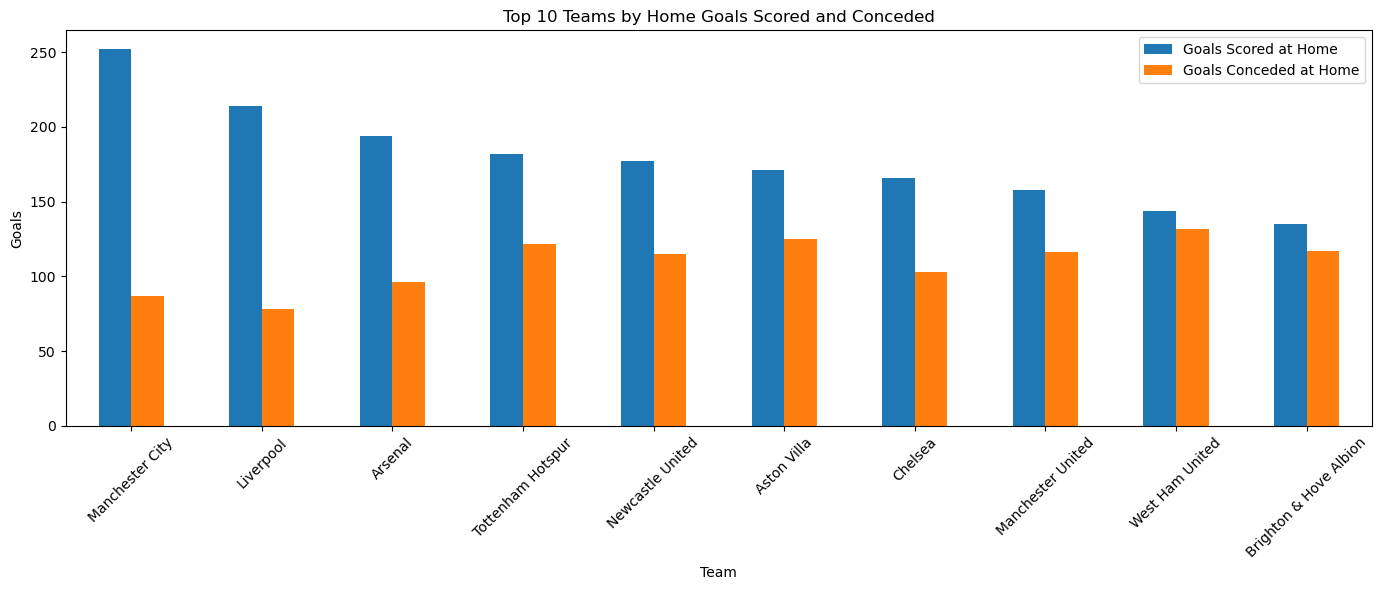

In [35]:
# Team Performance (Goals Scored & Conceded at Home)
team_goals = merged_df.groupby('HomeTeam')[['FTHG', 'FTAG']].sum().rename(
    columns={'FTHG': 'Goals Scored at Home', 'FTAG': 'Goals Conceded at Home'}
).sort_values('Goals Scored at Home', ascending=False)

team_goals.head(10).plot(kind='bar', figsize=(14, 6))
plt.title('Top 10 Teams by Home Goals Scored and Conceded')
plt.xlabel('Team')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

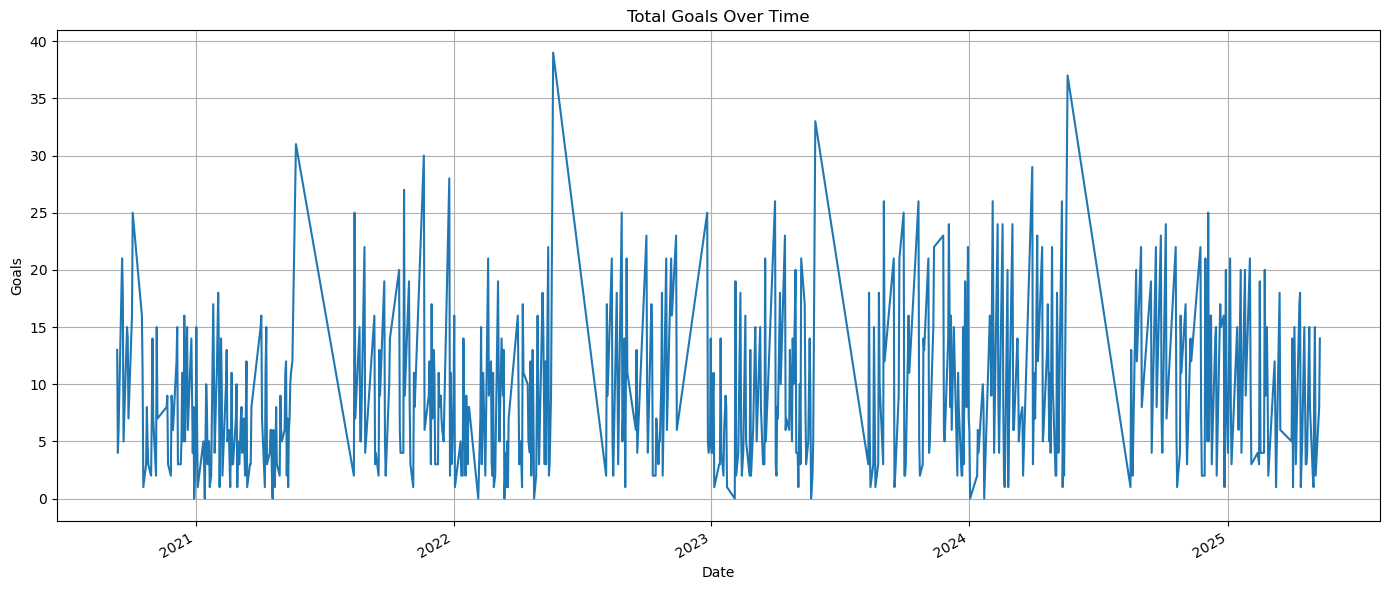

In [37]:
#Time Series of Total Goals per Match Day
goals_ts = merged_df.groupby('Date')[['FTHG', 'FTAG']].sum()
goals_ts['Total Goals'] = goals_ts['FTHG'] + goals_ts['FTAG']

plt.figure(figsize=(14, 6))
goals_ts['Total Goals'].plot()
plt.title('Total Goals Over Time')
plt.xlabel('Date')
plt.ylabel('Goals')
plt.grid(True)
plt.tight_layout()
plt.show()

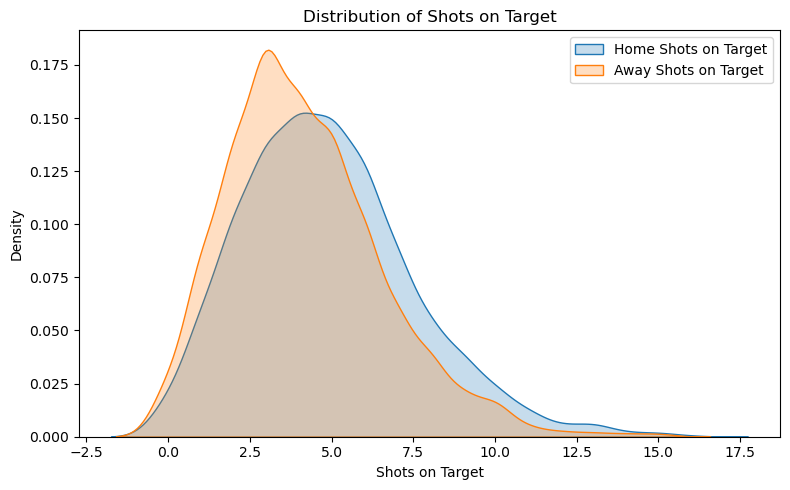

In [39]:
# Distribution of Shots on Target (Home vs Away)
plt.figure(figsize=(8, 5))
sns.kdeplot(merged_df['HST'], fill=True, label='Home Shots on Target')
sns.kdeplot(merged_df['AST'], fill=True, label='Away Shots on Target')
plt.title('Distribution of Shots on Target')
plt.xlabel('Shots on Target')
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare dropdown options
teams = sorted(set(merged_df['HomeTeam']).union(set(merged_df['AwayTeam'])))
seasons = sorted(merged_df['Season'].unique())

@interact_manual(
    team=widgets.Dropdown(options=teams, description='Team:'),
    season=widgets.Dropdown(options=seasons, description='Season:')
)
def team_stats(team, season):
    team_df = merged_df[(merged_df['Season'] == season) & 
                        ((merged_df['HomeTeam'] == team) | (merged_df['AwayTeam'] == team))].copy()
    
    if team_df.empty:
        print("No data available for selected team and season.")
        return

    # Compute stats
    team_df['Goals Scored'] = team_df.apply(
        lambda row: row['FTHG'] if row['HomeTeam'] == team else row['FTAG'], axis=1)
    team_df['Goals Conceded'] = team_df.apply(
        lambda row: row['FTAG'] if row['HomeTeam'] == team else row['FTHG'], axis=1)

    team_df['Match Result'] = team_df.apply(
        lambda row: 'Win' if (row['HomeTeam'] == team and row['FTR'] == 'H') or
                              (row['AwayTeam'] == team and row['FTR'] == 'A') else
                    ('Draw' if row['FTR'] == 'D' else 'Loss'), axis=1)

    # Plot goals time series
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=team_df, x='Date', y='Goals Scored', label='Scored', ax=axs[0])
    sns.lineplot(data=team_df, x='Date', y='Goals Conceded', label='Conceded', ax=axs[0])
    axs[0].set_title(f"{team} - Goals (Season {season})")
    axs[0].legend()

    # Plot result counts
    result_counts = team_df['Match Result'].value_counts()
    sns.barplot(x=result_counts.index, y=result_counts.values, hue=result_counts.index, palette='Set2', legend=False, ax=axs[1])
    axs[1].set_title(f"{team} - Match Outcomes (Season {season})")
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='Team:', options=('Arsenal', 'Aston Villa', 'Bournemouth', 'Brentfo…

In [43]:
from ipywidgets import interact_manual, Dropdown
import matplotlib.pyplot as plt
import seaborn as sns

@interact_manual(
    team1=Dropdown(options=teams, description='Team 1:'),
    team2=Dropdown(options=teams, description='Team 2:'),
    season=Dropdown(options=seasons, description='Season:')
)
def head_to_head(team1, team2, season):
    if team1 == team2:
        print("Please select two different teams.")
        return

    # Filter head-to-head matches
    h2h_df = merged_df[(merged_df['Season'] == season) & (
        ((merged_df['HomeTeam'] == team1) & (merged_df['AwayTeam'] == team2)) |
        ((merged_df['HomeTeam'] == team2) & (merged_df['AwayTeam'] == team1))
    )]

    if h2h_df.empty:
        print("No head-to-head matches found for selected season.")
        return

    # Determine result from perspective of team1
    def match_result(row):
        if row['HomeTeam'] == team1:
            return 'Win' if row['FTR'] == 'H' else ('Loss' if row['FTR'] == 'A' else 'Draw')
        else:
            return 'Win' if row['FTR'] == 'A' else ('Loss' if row['FTR'] == 'H' else 'Draw')

    h2h_df['Team1_Result'] = h2h_df.apply(match_result, axis=1)

    # Goals
    h2h_df['Team1_Goals'] = h2h_df.apply(lambda row: row['FTHG'] if row['HomeTeam'] == team1 else row['FTAG'], axis=1)
    h2h_df['Team2_Goals'] = h2h_df.apply(lambda row: row['FTAG'] if row['HomeTeam'] == team1 else row['FTHG'], axis=1)

    print(f"\nHead-to-Head Matches ({season}): {len(h2h_df)}")
    print(f"Avg Goals Scored: {team1}: {h2h_df['Team1_Goals'].mean():.2f}, {team2}: {h2h_df['Team2_Goals'].mean():.2f}")
    print(f"{team1} Results: \n{h2h_df['Team1_Result'].value_counts()}")

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x='Team1_Result', data=h2h_df, palette='Set1', ax=ax)
    ax.set_title(f"{team1} vs {team2} - Result Distribution ({season})")
    ax.set_xlabel('Result for ' + team1)
    ax.set_ylabel('Match Count')
    plt.show()


interactive(children=(Dropdown(description='Team 1:', options=('Arsenal', 'Aston Villa', 'Bournemouth', 'Brent…

# Additional Features

In [14]:
# avoid division by zero
eps = 1e-6

# Pre-match form & ranking features
merged_df['HWinRate'] = merged_df['HWon'] / (merged_df['HPlayed'] + eps)
merged_df['AWinRate'] = merged_df['AWon'] / (merged_df['APlayed'] + eps)
merged_df['HDrawRate'] = merged_df['HDrawn'] / (merged_df['HPlayed'] + eps)
merged_df['ADrawRate'] = merged_df['ADrawn'] / (merged_df['APlayed'] + eps)
merged_df['HLossRate'] = merged_df['HLost'] / (merged_df['HPlayed'] + eps)
merged_df['ALossRate'] = merged_df['ALost'] / (merged_df['APlayed'] + eps)

merged_df['PosDiff'] = merged_df['APos'] - merged_df['HPos']
merged_df['PosRatio'] = merged_df['HPos'] / (merged_df['APos'] + eps)

# Pre-match betting odds features
merged_df['AvgH'] = merged_df[['B365H', 'BWH', 'PSH', 'WHH']].mean(axis=1)
merged_df['AvgD'] = merged_df[['B365D', 'BWD', 'PSD', 'WHD']].mean(axis=1)
merged_df['AvgA'] = merged_df[['B365A', 'BWA', 'PSA', 'WHA']].mean(axis=1)

merged_df['MaxH'] = merged_df[['B365H', 'BWH', 'PSH', 'WHH']].max(axis=1)
merged_df['MaxD'] = merged_df[['B365D', 'BWD', 'PSD', 'WHD']].max(axis=1)
merged_df['MaxA'] = merged_df[['B365A', 'BWA', 'PSA', 'WHA']].max(axis=1)

merged_df['HDRatio'] = merged_df['AvgH'] / (merged_df['AvgD'] + eps)
merged_df['HARatio'] = merged_df['AvgH'] / (merged_df['AvgA'] + eps)
merged_df['DARatio'] = merged_df['AvgD'] / (merged_df['AvgA'] + eps)

#Save the csv file to dataset folder
#merged_df.to_csv(os.path.join(folder_path, 'final.csv'), index=False)
#print(f"\n Merged dataset saved to: {os.path.join(folder_path, 'final.csv')}")

# Prediction Model 1: In_match_prediction

In [15]:
# Features
feature_cols = [
    'HTHG', 'HTAG',
    'B365H', 'B365D', 'B365A',
    'BWH', 'BWD', 'BWA',
    'PSH', 'PSD', 'PSA',
    'WHH', 'WHD', 'WHA',
    'AvgH', 'AvgD', 'AvgA',
    'MaxH', 'MaxD', 'MaxA',
    'HPos','HPlayed','HWon','HDrawn','HLost',
    'APos','APlayed','AWon','ADrawn','ALost',
    'HWinRate','AWinRate',
    'HDrawRate','ADrawRate',
    'HLossRate','ALossRate',
    'PosDiff','PosRatio',
    'HDRatio','HARatio','DARatio'
]

X = merged_df[feature_cols]
y = merged_df['FTR']  # Target: H, D, A

# Features Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search for Best Parameters

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],                  
    'max_features': ['sqrt', 'log2', None],            
    'class_weight': ['balanced', 'balanced_subsample'] # Handle imbalanced classes
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)

# Model Evaluation
best_model = grid_search.best_estimator_
print("\n ------ Best Parameters ------ \n")
print(grid_search.best_params_)

# Evaluate using cross-validated predictions
y_pred = cross_val_predict(best_model, X_scaled, y, cv=cv)

print("\n ------ Confusion Matrix ------ \n")
print(confusion_matrix(y, y_pred))

print("\n ------ Classification Report ------ \n ")
print(classification_report(y, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits

 ------ Best Parameters ------ 

{'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 ------ Confusion Matrix ------ 

[[451  79 108]
 [134 132 165]
 [ 98 112 601]]

 ------ Classification Report ------ 
 
              precision    recall  f1-score   support

           A       0.66      0.71      0.68       638
           D       0.41      0.31      0.35       431
           H       0.69      0.74      0.71       811

    accuracy                           0.63      1880
   macro avg       0.59      0.58      0.58      1880
weighted avg       0.61      0.63      0.62      1880



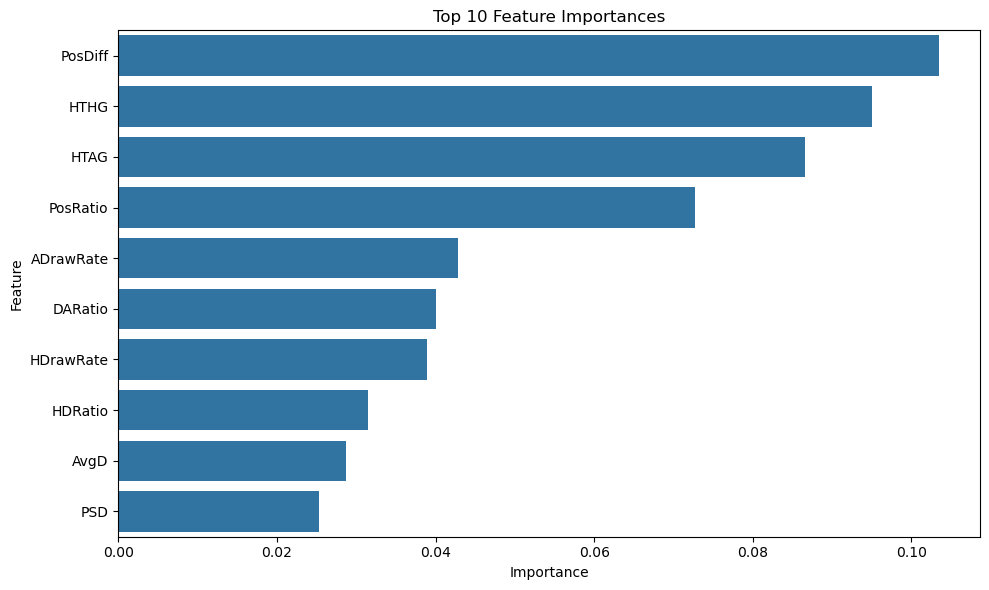

In [16]:
# Feature Importance Plot
importances = best_model.feature_importances_
feat_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
folder_path = '../data/in_match_predict'
save_path = "../models"
# Save the model
joblib.dump(best_model, os.path.join(save_path, "in_match_result_model.pkl"))
joblib.dump(scaler, os.path.join(save_path, "in_match_result_scaler.pkl"))

In [ ]:
# Statistics of home win rate
home_results = merged_df.groupby('HomeTeam').agg(
    HomeGames=('FTR', 'count'),
    HomeWins=('FTR', lambda x: (x == 'H').sum())
)
home_results['HomeWinRate'] = home_results['HomeWins'] / home_results['HomeGames']

# Statistics of away win rate
away_results = merged_df.groupby('AwayTeam').agg(
    AwayGames=('FTR', 'count'),
    AwayWins=('FTR', lambda x: (x == 'A').sum())
)
away_results['AwayWinRate'] = away_results['AwayWins'] / away_results['AwayGames']

# Combined into a complete win rate table
winrate_df = pd.merge(
    home_results[['HomeWinRate']],
    away_results[['AwayWinRate']],
    left_index=True, right_index=True,
    how='outer'
).reset_index().rename(columns={'index': 'Team'})

# Save as CSV
winrate_df.to_csv("team_winrates.csv", index=False)

This part focuses on building a Random Forest-based machine learning model to predict the outcomes of football matches (home win, draw, or away win). After generating predictions, a rule-based logic is applied using each team's historical win rate to provide betting recommendations. This logic helps determine whether the model's prediction is reliable enough to support an actual betting decision.

The final output, including both the predicted results and corresponding betting recommendations, is saved for use in the Streamlit frontend, enabling visual presentation and user interaction.

In [ ]:
# Model predictions output
pred_result = model.predict(X_input)[0]  

# Define the betting judgment function
def betting_recommendation(pred_result, home_winrate, away_winrate, draw_gap=0.05):
    if pred_result == 'H':
        return 'Bet' if home_winrate > away_winrate else 'No Bet'
    elif pred_result == 'A':
        return 'Bet' if away_winrate > home_winrate else 'No Bet'
    elif pred_result == 'D':
        return 'Bet' if abs(home_winrate - away_winrate) <= draw_gap else 'No Bet'
    else:
        return 'Unknown'

# Call for betting advice
bet_suggestion = betting_recommendation(pred_result, home_winrate, away_winrate)

# Show results
st.markdown(f"###  Model Prediction: **{pred_result}**")
st.markdown(f"###  Betting Advice: **{bet_suggestion}**")
st.markdown(f" Home Win Rate: {home_winrate:.2f}   Away Win Rate: {away_winrate:.2f}")

## Prediction Model 2: Player_value_prediction

In [132]:
# Train the player_value_prediction model
def train_model():
    base_path = os.path.dirname(os.path.abspath(__file__))
    database_path = os.path.join(base_path, '..', 'data', 'allData.sl3')
    conn = sqlite3.connect(database_path)
    df = pd.read_sql_query("SELECT * FROM player_stats WHERE value != 0 and wage != 0", conn)
    conn.close()

    df['value'] = np.log(df['value'])
    df['wage'] = np.log(df['wage'])

    X = df.drop(columns=['full_name', 'value', 'wage', 'year'])
    y = df['value']

    if 'best_position' in X.columns:
        X = pd.get_dummies(X, columns=['best_position'])

    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype(str).str.extract(r'(\d+)')
            X[col] = pd.to_numeric(X[col], errors='coerce')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # y_perd = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_perd)
    # print(mse)
    joblib.dump(model, 'models/player_value_model.pkl')

In [128]:
# Load the player_value_prediction model to predict the player's value
def predict_player_value(player_dict):
    base_path = os.path.dirname(os.path.abspath(__file__))
    model_path = os.path.join('models/player_value_model.pkl')
    try:
        model = joblib.load(model_path)
    except (FileNotFoundError, EOFError, Exception):
        print("Training model...")
        train_model()
        model = joblib.load(model_path)

    df = pd.DataFrame([player_dict])
    for col in ['Stamina', 'Dribbling', 'Short passing']:
        df[col] = df[col].astype(float)

    if 'Best position' in df.columns:
        df = pd.get_dummies(df)

    model_columns = model.feature_names_in_
    for col in model_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[model_columns]

    log_pred = model.predict(df)[0]
    return np.exp(log_pred)

In [ ]:
# Call this function for the first time to build the model
train_model()

## Prediction Model 3: Pre_match_prediction

In [140]:
# Get data from database
db_path = "data/allData.sl3"
conn = sqlite3.connect(db_path)

df = pd.read_sql_query("""SELECT
    m.*,

    -- Home Team Rating
    th.overall AS home_overall,
    th.attack AS home_attack,
    th.midfield AS home_midfield,
    th.defence AS home_defence,
    th.players AS home_players,

    -- Away Team Rating
    ta.overall AS away_overall,
    ta.attack AS away_attack,
    ta.midfield AS away_midfield,
    ta.defence AS away_defence,
    ta.players AS away_players

FROM match_stats AS m

LEFT JOIN team_stats AS th
    ON m.home_team = th.team AND substr(m.season, 1, 4) = CAST(th.year AS TEXT)

LEFT JOIN team_stats AS ta
    ON m.away_team = ta.team AND substr(m.season, 1, 4) = CAST(ta.year AS TEXT);""", conn)
conn.close()

In [ ]:
# Build the LogisticRegression Model
df = df.dropna(subset=[
    'b365_prob_h', 'b365_prob_d', 'b365_prob_a',
    'home_overall', 'home_attack', 'home_midfield', 'home_defence', 'home_players',
    'away_overall', 'away_attack', 'away_midfield', 'away_defence', 'away_players',
    'ftr'
])

df = df[df['ftr'] != 'D']
df['ftr_encoded'] = df['ftr'].map({'H': 0, 'A': 1})
df['overall_diff'] = df['home_overall'] - df['away_overall']
df['attack_diff'] = df['home_attack'] - df['away_attack']
df['midfield_diff'] = df['home_midfield'] - df['away_midfield']
df['defence_diff'] = df['home_defence'] - df['away_defence']
df['age_diff'] = df['home_players'] - df['away_players']

features = [
    'b365_prob_h', 'b365_prob_d', 'b365_prob_a',
    'overall_diff', 'attack_diff', 'midfield_diff',
    'defence_diff', 'age_diff'
]
X = df[features]
y = df['ftr_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)

grid.fit(X_scaled, y)
best_model = grid.best_estimator_
best_params = grid.best_params_
cv_score = grid.best_score_

print("Optimal parameters：", best_params)
print("Cross-validation accuracy：{:.2f}%".format(cv_score * 100))

y_pred = best_model.predict(X_scaled[:1000])
print("Accuracy：{:.2f}%".format(accuracy_score(y[:1000], y_pred) * 100))
print("classification_report:")
print(classification_report(y[:1000], y_pred, target_names=['Home Win', 'Away Win']))
joblib.dump(best_model, "models/pre_match_result_model.pkl")
joblib.dump(scaler, "models/pre_match_result_scaler.pkl")